In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, inspect, func, MetaData
from sqlalchemy import Column, Integer, String, Float 

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///SurfsUp/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
order_by_dates = session.query(measurement.date).order_by(measurement.date.desc())
recent_date = dt.date.fromisoformat(order_by_dates[0][0])
recent_date

datetime.date(2017, 8, 23)

            date  precipitation
0     2016-08-23            0.0
1     2016-08-23            3.8
2     2016-08-23            1.3
3     2016-08-23            NaN
4     2016-08-23            0.5
...          ...            ...
2225  2017-08-22           12.7
2228  2017-08-23            2.0
2226  2017-08-23            0.0
2227  2017-08-23            0.0
2229  2017-08-23           11.4

[2230 rows x 2 columns]


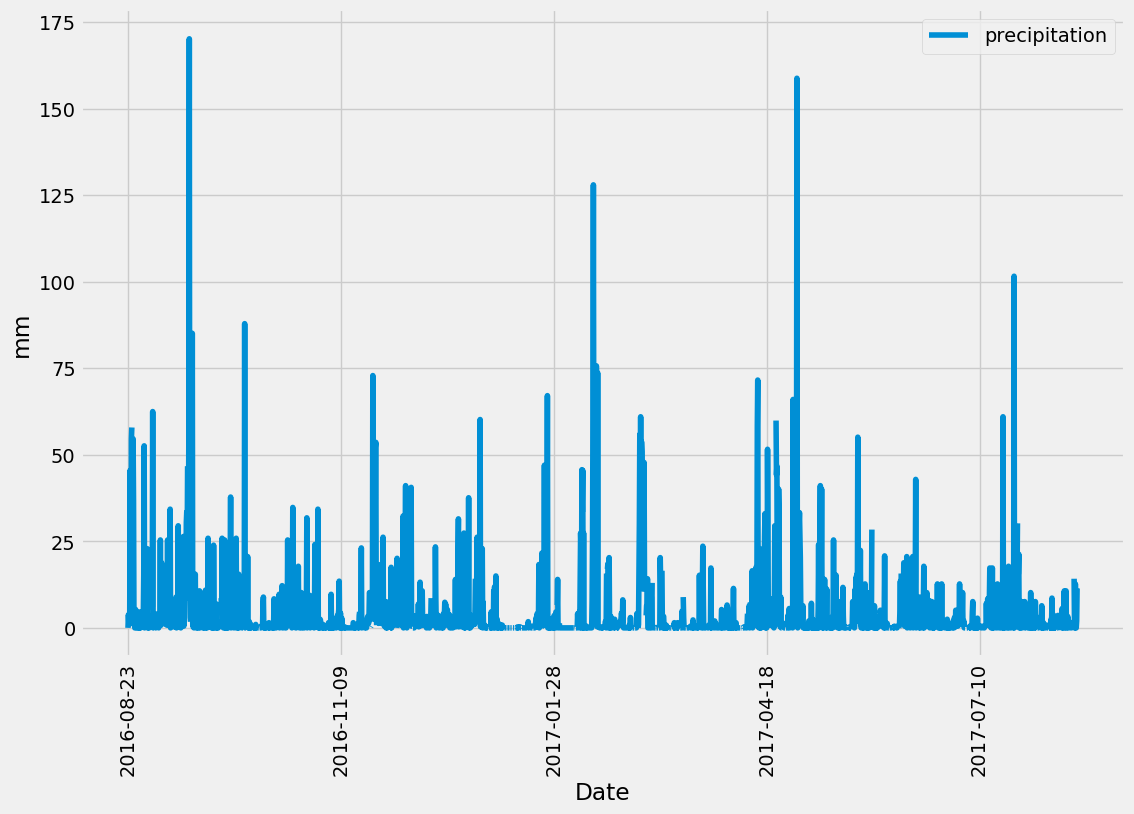

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twelve_months_ago = recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
prcp_score = session.query(measurement.date, measurement.prcp).filter(measurement.date >= twelve_months_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_score_df = pd.DataFrame(prcp_score, columns=['date', 'precipitation'])

# Sort the DataFrame by date
df_by_date = prcp_score_df.sort_values(by='date')

# Print the sorted DataFrame
print(df_by_date)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_score_df.plot(x='date', y='precipitation', figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_score_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# = session.query(station_table).count()
Station = session.query(station).count()
Station

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_total = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations_total

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_total[0][0]
print(f"The station with the greatest number of observations is {most_active_station}")
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()
# Print the results
print(f"The lowest temperature for station {most_active_station} is {temp_stats[0][0]} degrees Fahrenheit.")
print(f"The highest temperature for station {most_active_station} is {temp_stats[0][1]} degrees Fahrenheit.")
print(f"The average temperature for station {most_active_station} is {temp_stats[0][2]} degrees Fahrenheit.")

The station with the greatest number of observations is USC00519281
The lowest temperature for station USC00519281 is 12.2 degrees Fahrenheit.
The highest temperature for station USC00519281 is 29.4 degrees Fahrenheit.
The average temperature for station USC00519281 is 22.03582251082252 degrees Fahrenheit.


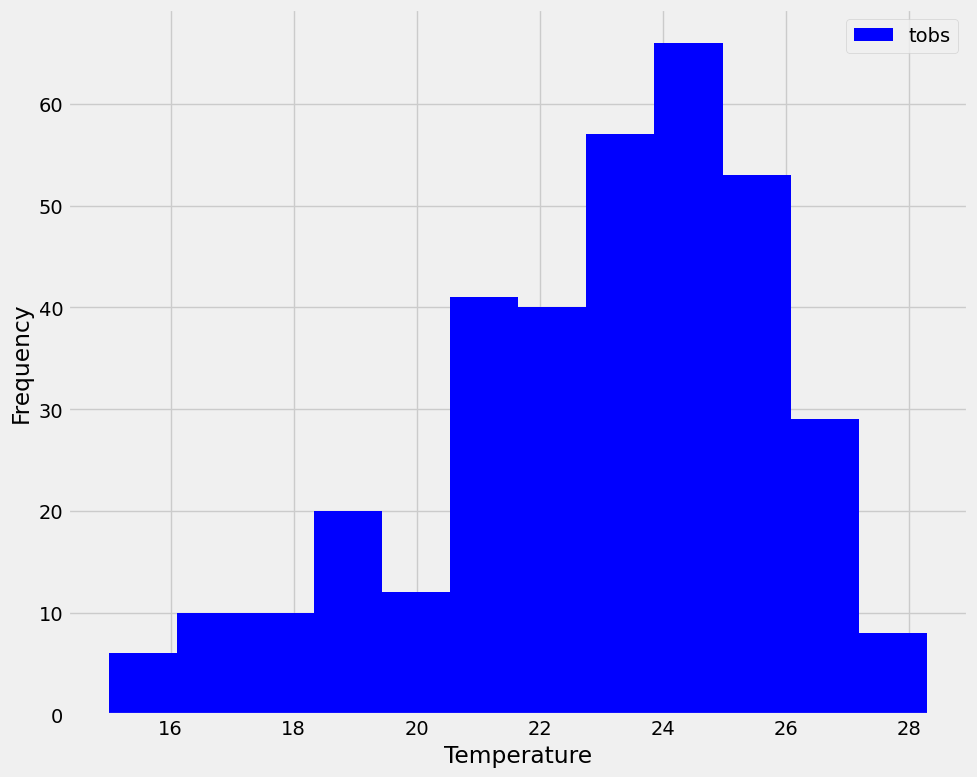

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_twelve_months_ago = (session.query(measurement.station, measurement.tobs)\
             .filter(measurement.date >= twelve_months_ago)\
             .filter(measurement.station == most_active_station).all())

most_active_df = pd.DataFrame(most_active_twelve_months_ago)

#and plot the results as a histogram
most_active_df.plot.hist(figsize = (10,8), color = 'blue', bins=12, legend=True)
plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()